In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dgomonov/new-york-city-airbnb-open-data")

print("Path to dataset files:", path)
data=pd.read_csv(path+"/AB_NYC_2019.csv")

100%|██████████| 2.44M/2.44M [00:00<00:00, 37.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/dgomonov/new-york-city-airbnb-open-data/versions/3


In [ ]:
# EDA
# Display the first few rows of the dataset
print("head: \n",data.head())
# Display total numbers of row and comlumns
print("shape: \n",data.shape)
#Display comlumn names
print("columns: \n",data.columns)
# Check for missing values
print("Sum of null values:\n",data.isnull().sum())
#check the data types
print("data types:\n",data.dtypes)

# Statistical summary
print("statistical summary:\n",data.describe())

head: 
      id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1               

In [ ]:
# Data Cleaning
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)  # Drop missing values
data.drop(columns=['id','host_id',"name","host_name","last_review","neighbourhood"],inplace=True)
data["reviews_per_month"].fillna(data["reviews_per_month"].mean(),inplace=True)
data = pd.get_dummies(data, columns=['neighbourhood_group', 'room_type'], drop_first=True)
# data = data[['price', 'number_of_reviews', 'availability_365']]  # Select relevant features

<ipython-input-6-29efca51fb3b>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["reviews_per_month"].fillna(data["reviews_per_month"].mean(),inplace=True)


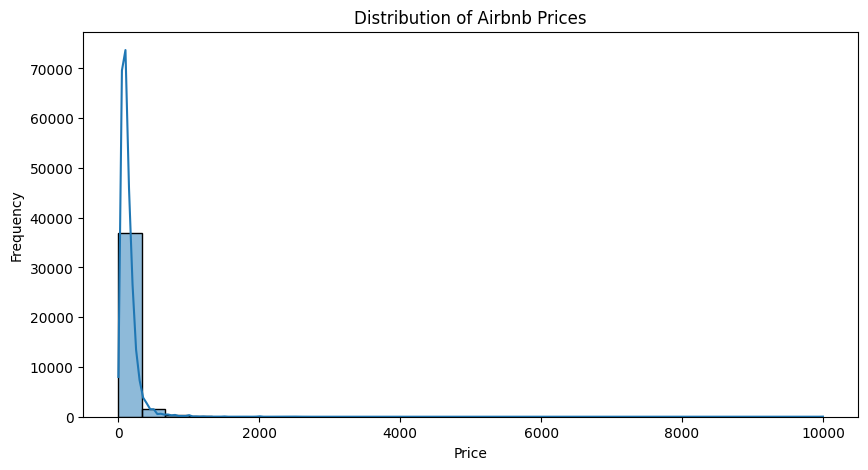

In [ ]:
# Data Visualization
# Histogram of the target variable
plt.figure(figsize=(10, 5))
sns.histplot(data['price'], bins=30, kde=True)
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

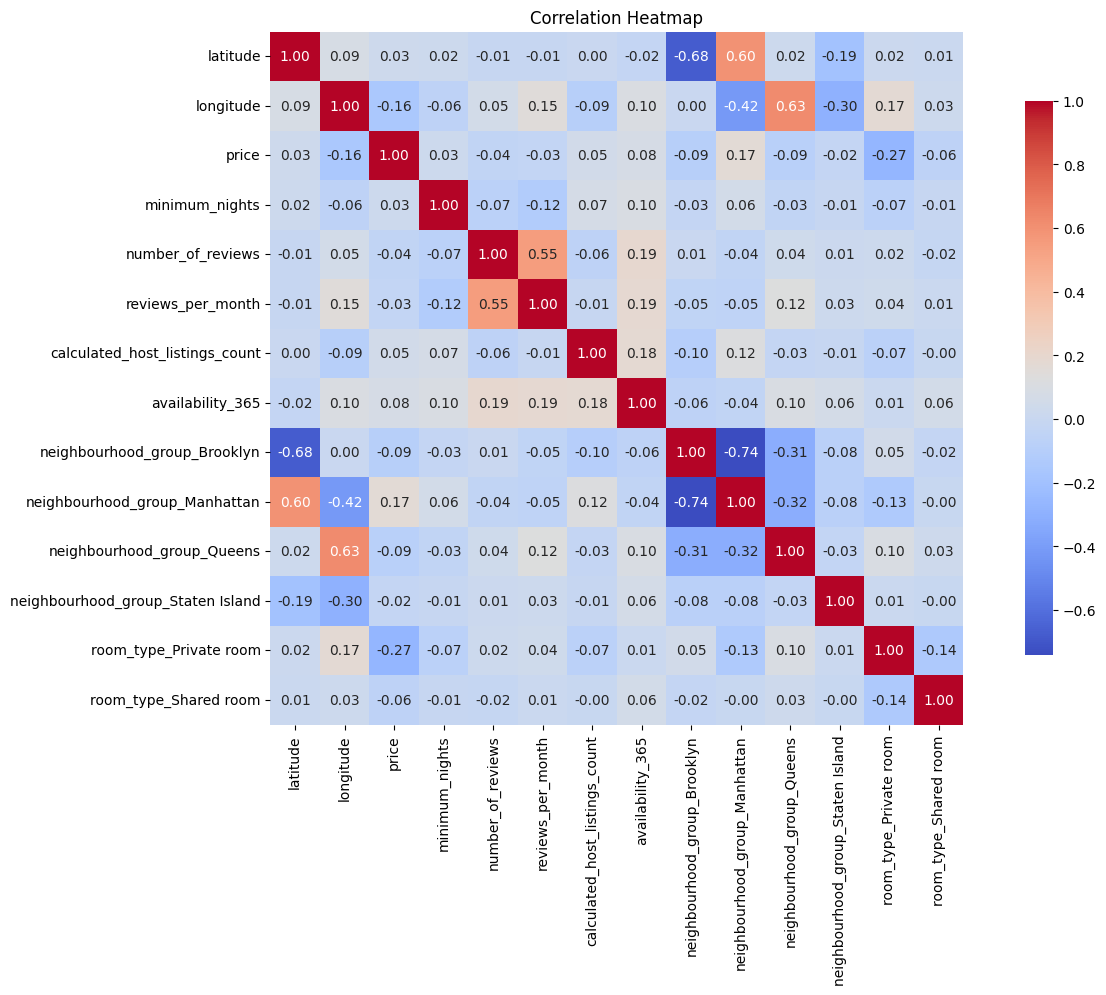

In [ ]:
#Heat map
plt.figure(figsize=(16, 9))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')

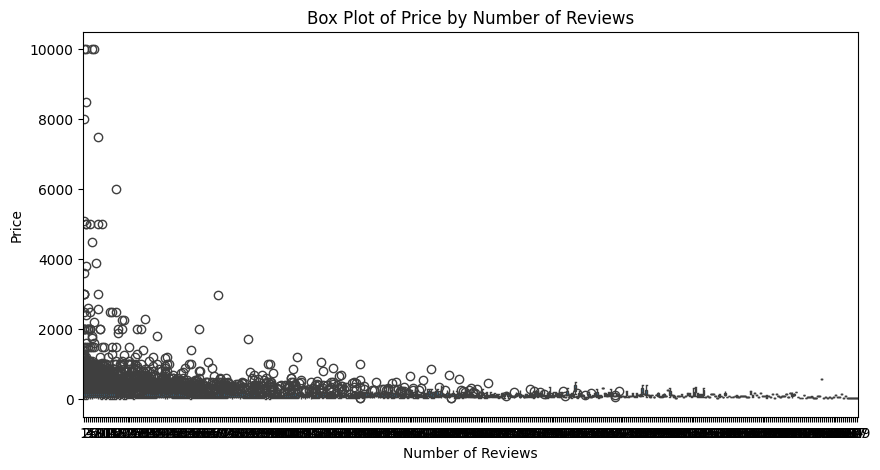

In [ ]:
# Box plot for feature analysis
plt.figure(figsize=(10, 5))
sns.boxplot(x='number_of_reviews', y='price', data=data)
plt.title('Box Plot of Price by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.show()

In [ ]:
data.shape

(38821, 14)

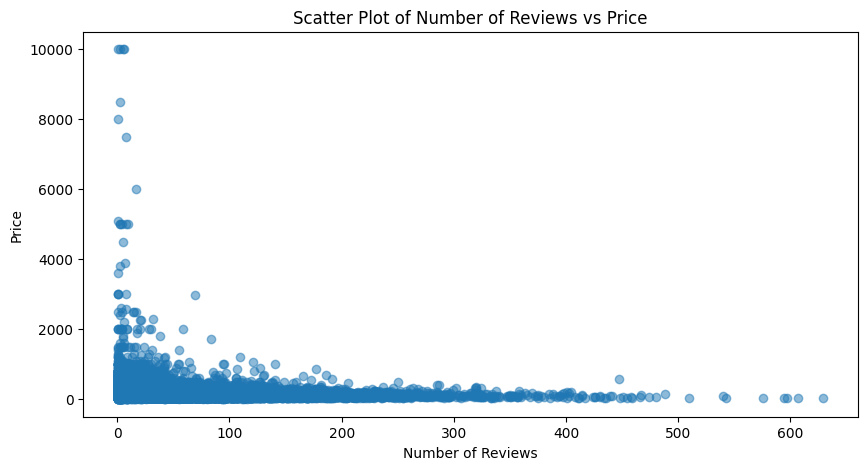

In [ ]:
# Scatter plot for feature analysis
plt.figure(figsize=(10, 5))
plt.scatter(data['number_of_reviews'], data['price'], alpha=0.5)
plt.title('Scatter Plot of Number of Reviews vs Price')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.show()

In [ ]:

# Prepare data for modeling
# Splitting the data into target and feature
data[data.select_dtypes(include=['bool']).columns] = data.select_dtypes(include=['bool']).astype(int)
X=data.drop(columns=["price"],axis=1).values #feature
y=data["price"].values #target
X


array([[ 40.64749, -73.97237,   1.     , ...,   0.     ,   1.     ,
          0.     ],
       [ 40.75362, -73.98377,   1.     , ...,   0.     ,   0.     ,
          0.     ],
       [ 40.68514, -73.95976,   1.     , ...,   0.     ,   0.     ,
          0.     ],
       ...,
       [ 40.54179, -74.14275,   1.     , ...,   1.     ,   1.     ,
          0.     ],
       [ 40.80787, -73.924  ,   1.     , ...,   0.     ,   0.     ,
          0.     ],
       [ 40.69805, -73.92801,   1.     , ...,   0.     ,   1.     ,
          0.     ]])

In [ ]:
data.dtypes

,0
latitude,float64
longitude,float64
price,int64
minimum_nights,int64
number_of_reviews,int64
reviews_per_month,float64
calculated_host_listings_count,int64
availability_365,int64
neighbourhood_group_Brooklyn,int64
neighbourhood_group_Manhattan,int64


In [ ]:
# Linear Regression from Scratch
def linear_regression(X, y, learning_rate=0.001, num_iterations=1000):
    num_samples, num_features = X.shape
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    weights = np.random.randn(num_features) * 0.01
    bias = 0

    for _ in range(num_iterations):
        y_predicted = np.dot(X, weights) + bias

        # Gradient Descent
        dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
        db = (1 / num_samples) * np.sum(y_predicted - y)

        weights -= learning_rate * dw
        bias -= learning_rate * db

    return weights, bias

def predict_linear(X, weights, bias):
    return np.dot(X, weights) + bias


In [ ]:
# Train-test split
np.random.seed(42)

indices = np.random.permutation(len(X))
train_size = int(len(X) * 0.8)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

In [ ]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

# Train Linear Regression
weights, bias = linear_regression(X_train, y_train)
weights
bias

90.10454213809916

In [ ]:
# Predictions
linear_predictions = predict_linear(X_test, weights, bias)
linear_predictions

array([ 47.33316415,  73.36721546,  43.08079269, ...,  58.25513241,
       153.17903522, 181.30815376])

In [ ]:
# Import necessary libraries
from sklearn.linear_model import Ridge, Lasso

In [ ]:
# Initialize the models
ridge_model = Ridge(alpha=1.0)  # You can adjust the alpha parameter
lasso_model = Lasso(alpha=0.1)   # You can adjust the alpha parameter

# Train the models
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

# Make predictions
ridge_predictions = ridge_model.predict(X_test)
lasso_predictions = lasso_model.predict(X_test)


In [ ]:
# Manual Evaluation Metrics Calculation

# Mean Absolute Error (MAE)
def mean_absolute_error_manual(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Root Mean Squared Error (RMSE)
def root_mean_squared_error_manual(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# R-squared
def r_squared_manual(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)


In [ ]:
# Evaluate Ridge Regression
ridge_mae = mean_absolute_error_manual(y_test, ridge_predictions)
ridge_rmse = root_mean_squared_error_manual(y_test, ridge_predictions)
ridge_r2 = r_squared_manual(y_test, ridge_predictions)



In [ ]:
# Evaluate Lasso Regression
lasso_mae = mean_absolute_error_manual(y_test, lasso_predictions)
lasso_rmse = root_mean_squared_error_manual(y_test, lasso_predictions)
lasso_r2 = r_squared_manual(y_test, lasso_predictions)

In [ ]:
# Print the evaluation metrics
print("Ridge Regression Performance:")
print(f"Mean Absolute Error: {ridge_mae:.2f}")
print(f"Root Mean Squared Error: {ridge_rmse:.2f}")
print(f"R-squared: {ridge_r2:.2f}")

print("\nLasso Regression Performance:")
print(f"Mean Absolute Error: {lasso_mae:.2f}")
print(f"Root Mean Squared Error: {lasso_rmse:.2f}")
print(f"R-squared: {lasso_r2:.2f}")

Ridge Regression Performance:
Mean Absolute Error: 61.62
Root Mean Squared Error: 229.42
R-squared: 0.07

Lasso Regression Performance:
Mean Absolute Error: 61.55
Root Mean Squared Error: 229.41
R-squared: 0.07


In [ ]:
# Create a DataFrame to compare the performance of Ridge and Lasso Regression
performance_data = {
    'Model': ['Ridge Regression', 'Lasso Regression'],
    'Mean Absolute Error': [ridge_mae, lasso_mae],
    'Root Mean Squared Error': [ridge_rmse, lasso_rmse],
    'R-squared': [ridge_r2, lasso_r2]
}

performance_df = pd.DataFrame(performance_data)

# Print the comparison table
print("\nComparison of Final Model Performance:")
print(performance_df)

# Determine which model is better based on R-squared
if ridge_r2 > lasso_r2:
    better_model = "Ridge Regression"
    better_score = ridge_r2
else:
    better_model = "Lasso Regression"
    better_score = lasso_r2

# Print the comparison statement
print(f"\nBased on the R-squared value, the better model is: {better_model} with an R-squared of {better_score:.2f}.")


Comparison of Final Model Performance:
              Model  Mean Absolute Error  Root Mean Squared Error  R-squared
0  Ridge Regression            61.622635               229.423113   0.068209
1  Lasso Regression            61.550334               229.410862   0.068309

Based on the R-squared value, the better model is: Lasso Regression with an R-squared of 0.07.


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define the hyperparameter grid for Ridge and Lasso
ridge_param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]  # You can expand this range as needed
}

lasso_param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]  # You can expand this range as needed
}
# Initialize the models
ridge_model = Ridge()
lasso_model = Lasso()

# Perform Grid Search for Ridge Regression
ridge_grid_search = GridSearchCV(estimator=ridge_model, param_grid=ridge_param_grid,
                                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)

# Perform Grid Search for Lasso Regression
lasso_grid_search = GridSearchCV(estimator=lasso_model, param_grid=lasso_param_grid,
                                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_ridge_alpha = ridge_grid_search.best_params_['alpha']
best_lasso_alpha = lasso_grid_search.best_params_['alpha']

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Ridge Regression - Best alpha: {best_ridge_alpha}")
print(f"Lasso Regression - Best alpha: {best_lasso_alpha}")

Best Hyperparameters:
Ridge Regression - Best alpha: 100.0
Lasso Regression - Best alpha: 0.1


In [ ]:
# Get the best hyperparameters
best_ridge_alpha = ridge_grid_search.best_params_['alpha']
best_lasso_alpha = lasso_grid_search.best_params_['alpha']

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Ridge Regression - Best alpha: {best_ridge_alpha}")
print(f"Lasso Regression - Best alpha: {best_lasso_alpha}")

Best Hyperparameters:
Ridge Regression - Best alpha: 100.0
Lasso Regression - Best alpha: 0.1


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# Step 1: Feature Selection using SelectKBest
# Select the top k features (you can adjust k based on your needs)
k = 5  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)

# Fit the selector to the training data
X_train_selected = selector.fit_transform(X_train, y_train)

# Transform the test data
X_test_selected = selector.transform(X_test)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Print the selected feature indices
print("Selected feature indices:", selected_indices)

# Optionally, print the scores of all features
feature_scores = selector.scores_
print("Feature scores:", feature_scores)

selected_features = data.columns[selected_indices]

print(selected_features)




Selected feature indices: [ 1  7  8  9 11]
Feature scores: [  40.19386738  917.25745853   15.52394521   41.00788866   30.39303584
  103.23424781  217.13537858  329.88417063 1104.55232545  295.11605572
   20.639772   2898.72033504  131.05769391]
Index(['longitude', 'availability_365', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Staten Island'],
      dtype='object')


In [ ]:
# Step 2: Train the models again using the selected features
ridge_model = Ridge(alpha=best_ridge_alpha)
lasso_model = Lasso(alpha=best_lasso_alpha)

# Fit Ridge Regression
ridge_model.fit(X_train_selected, y_train)
ridge_predictions_selected = ridge_model.predict(X_test_selected)

# Fit Lasso Regression
lasso_model.fit(X_train_selected, y_train)
lasso_predictions_selected = lasso_model.predict(X_test_selected)


In [ ]:
# Step 3: Evaluate the models again using the selected features
ridge_mae_selected = mean_absolute_error_manual(y_test, ridge_predictions_selected)
ridge_rmse_selected = root_mean_squared_error_manual(y_test, ridge_predictions_selected)
ridge_r2_selected = r_squared_manual(y_test, ridge_predictions_selected)

lasso_mae_selected = mean_absolute_error_manual(y_test, lasso_predictions_selected)
lasso_rmse_selected = root_mean_squared_error_manual(y_test, lasso_predictions_selected)
lasso_r2_selected = r_squared_manual(y_test, lasso_predictions_selected)

In [ ]:
# Print the evaluation metrics for the models with selected features
print("\nRidge Regression Performance with Selected Features:")
print(f"Mean Absolute Error: {ridge_mae_selected:.2f}")
print(f"Root Mean Squared Error: {ridge_rmse_selected:.2f}")
print(f"R-squared: {ridge_r2_selected:.2f}")

print("\nLasso Regression Performance with Selected Features:")
print(f"Mean Absolute Error: {lasso_mae_selected:.2f}")
print(f"Root Mean Squared Error: {lasso_rmse_selected:.2f}")
print(f"R-squared: {lasso_r2_selected:.2f}")


Ridge Regression Performance with Selected Features:
Mean Absolute Error: 62.85
Root Mean Squared Error: 231.19
R-squared: 0.05

Lasso Regression Performance with Selected Features:
Mean Absolute Error: 62.83
Root Mean Squared Error: 231.19
R-squared: 0.05


In [ ]:
# Rebuild the Ridge Regression model with optimal hyperparameters and selected features
final_ridge_model = Ridge(alpha=best_ridge_alpha)
final_ridge_model.fit(X_train_selected, y_train)

# Make predictions with the final Ridge model
final_ridge_predictions = final_ridge_model.predict(X_test_selected)

# Evaluate the final Ridge model
final_ridge_mae = mean_absolute_error_manual(y_test, final_ridge_predictions)
final_ridge_rmse = root_mean_squared_error_manual(y_test, final_ridge_predictions)
final_ridge_r2 = r_squared_manual(y_test, final_ridge_predictions)

In [ ]:
# Rebuild the Lasso Regression model with optimal hyperparameters and selected features
final_lasso_model = Lasso(alpha=best_lasso_alpha)
final_lasso_model.fit(X_train_selected, y_train)

# Make predictions with the final Lasso model
final_lasso_predictions = final_lasso_model.predict(X_test_selected)

# Evaluate the final Lasso model
final_lasso_mae = mean_absolute_error_manual(y_test, final_lasso_predictions)
final_lasso_rmse = root_mean_squared_error_manual(y_test, final_lasso_predictions)
final_lasso_r2 = r_squared_manual(y_test, final_lasso_predictions)

In [ ]:
# Print the evaluation metrics for the final models
print("\nFinal Ridge Regression Performance:")
print(f"Mean Absolute Error: {final_ridge_mae:.2f}")
print(f"Root Mean Squared Error: {final_ridge_rmse:.2f}")
print(f"R-squared: {final_ridge_r2:.2f}")

print("\nFinal Lasso Regression Performance:")
print(f"Mean Absolute Error: {final_lasso_mae:.2f}")
print(f"Root Mean Squared Error: {final_lasso_rmse:.2f}")
print(f"R-squared: {final_lasso_r2:.2f}")


Final Ridge Regression Performance:
Mean Absolute Error: 62.85
Root Mean Squared Error: 231.19
R-squared: 0.05

Final Lasso Regression Performance:
Mean Absolute Error: 62.83
Root Mean Squared Error: 231.19
R-squared: 0.05


In [ ]:
# Create a DataFrame to compare the performance of Ridge and Lasso Regression
performance_data = {
    'Model': ['Ridge Regression', 'Lasso Regression'],
    'Mean Absolute Error': [final_ridge_mae, final_lasso_mae],
    'Root Mean Squared Error': [final_ridge_rmse, final_lasso_rmse],
    'R-squared': [final_ridge_r2, final_lasso_r2]
}

performance_df = pd.DataFrame(performance_data)

# Print the comparison table
print("\nComparison of Final Model Performance:")
print(performance_df)

# Determine which model is better based on R-squared
if final_ridge_r2 > final_lasso_r2:
    better_model = "Ridge Regression"
    better_score = final_ridge_r2
else:
    better_model = "Lasso Regression"
    better_score = final_lasso_r2

# Print the comparison statement
print(f"\nBased on the R-squared value, the better model is: {better_model} with an R-squared of {better_score:.2f}.")


Comparison of Final Model Performance:
              Model  Mean Absolute Error  Root Mean Squared Error  R-squared
0  Ridge Regression            62.845853               231.185299   0.053840
1  Lasso Regression            62.825933               231.188706   0.053812

Based on the R-squared value, the better model is: Ridge Regression with an R-squared of 0.05.


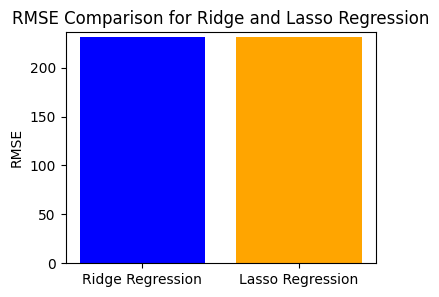

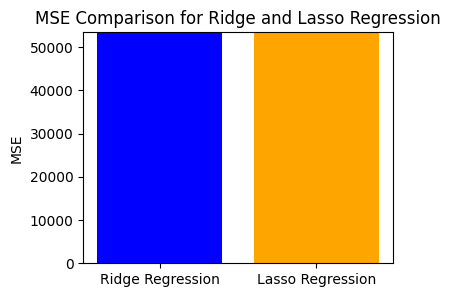

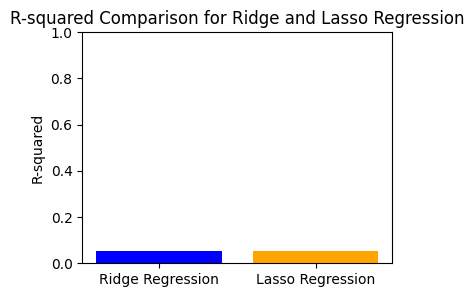

In [ ]:
import matplotlib.pyplot as plt

# Final evaluation metrics from the provided code
final_ridge_rmse = final_ridge_rmse  # RMSE for Ridge
final_lasso_rmse = final_lasso_rmse  # RMSE for Lasso

# Calculate MSE from RMSE
final_ridge_mse = final_ridge_rmse ** 2  # MSE for Ridge
final_lasso_mse = final_lasso_rmse ** 2  # MSE for Lasso

# R-squared values
final_ridge_r2 = final_ridge_r2  # R-squared for Ridge
final_lasso_r2 = final_lasso_r2  # R-squared for Lasso

# Prepare data for plotting
ridge_values_rmse = [final_ridge_rmse]
lasso_values_rmse = [final_lasso_rmse]

ridge_values_mse = [final_ridge_mse]
lasso_values_mse = [final_lasso_mse]

ridge_values_r2 = [final_ridge_r2]
lasso_values_r2 = [final_lasso_r2]

# Create RMSE Bar Plot
plt.figure(figsize=(4, 3))
plt.bar(['Ridge Regression', 'Lasso Regression'], ridge_values_rmse + lasso_values_rmse, color=['blue', 'orange'])
plt.ylabel('RMSE')
plt.title('RMSE Comparison for Ridge and Lasso Regression')
plt.ylim(0, max(ridge_values_rmse + lasso_values_rmse) + 5)
plt.show()

# Create MSE Bar Plot
plt.figure(figsize=(4, 3))
plt.bar(['Ridge Regression', 'Lasso Regression'], ridge_values_mse + lasso_values_mse, color=['blue', 'orange'])
plt.ylabel('MSE')
plt.title('MSE Comparison for Ridge and Lasso Regression')
plt.ylim(0, max(ridge_values_mse + lasso_values_mse) + 5)
plt.show()

# Create R-squared Bar Plot
plt.figure(figsize=(4, 3))
plt.bar(['Ridge Regression', 'Lasso Regression'], ridge_values_r2 + lasso_values_r2, color=['blue', 'orange'])
plt.ylabel('R-squared')
plt.title('R-squared Comparison for Ridge and Lasso Regression')
plt.ylim(0, 1)  # R-squared values are typically between 0 and 1
plt.show()

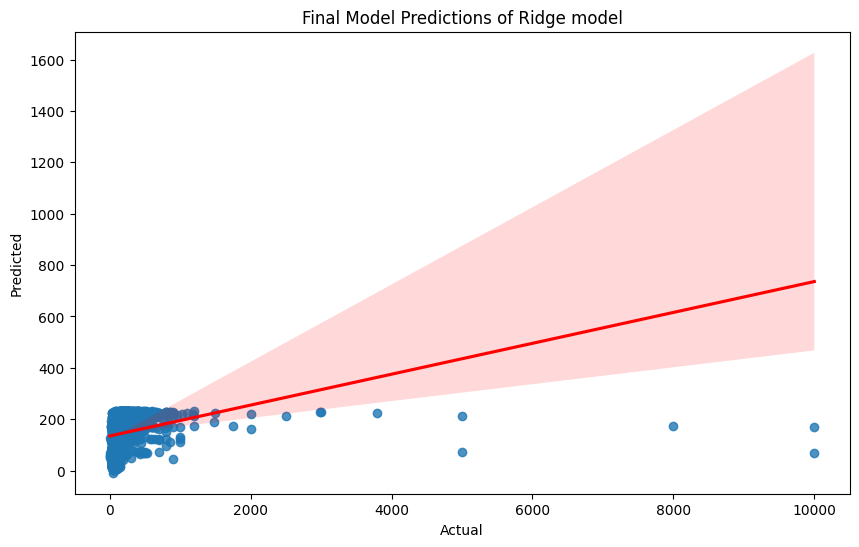

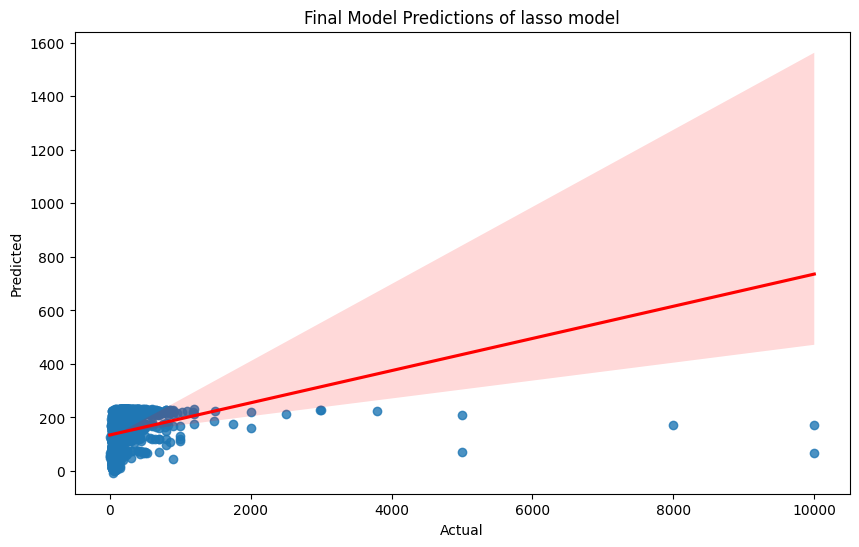

In [ ]:
# Final visualization
results = pd.DataFrame({'Actual': y_test, 'Predicted': final_ridge_predictions})

plt.figure(figsize=(10,6))
sns.regplot(x='Actual', y='Predicted', data=results, line_kws={'color':'red'})
plt.title("Final Model Predictions of Ridge model")
plt.show()
# Final visualization
results = pd.DataFrame({'Actual': y_test, 'Predicted': final_lasso_predictions})

plt.figure(figsize=(10,6))
sns.regplot(x='Actual', y='Predicted', data=results, line_kws={'color':'red'})
plt.title("Final Model Predictions of lasso model")
plt.show()